## Chargement et Prétraitement du Dataset

** Importer les bibliothèques nécessaires.

In [ ]:
! pip install opencv-python

In [ ]:
! pip install tensorflow

In [ ]:
! pip install streamlit

In [32]:
# Traitement et gestion des données
import numpy as np
import pandas as pd
import os
import cv2
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Deep Learning (Keras / TensorFlow)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Mesure du temps d’entraînement
import time

# Interface (pour le déploiement avec Streamlit)
import streamlit as st

***** Variables utilisées dans ce projet :

labels : liste contenant les noms des classes. 
         ['glioma' 'meningioma' 'notumor' 'pituitary']

images : liste contenant les images.

dict_labels_images_count : dictionnaire contenant chaque label de classe comme clé et le nombre total d’images associées comme valeur.

dict_labels_list_images_index : dictionnaire contenant chaque label de classe comme clé et la liste des index des images correspondantes comme valeur.
    glioma : [   8    9   12 ... 7006 7014 7022]
    meningioma : [   1    2    6 ... 7007 7008 7017]
    notumor : [   0    3   13 ... 7018 7019 7020]
    pituitary : [   4    5   11 ... 7015 7016 7021]

In [33]:
images = []
labels = []
dict_labels_list_images_index = {}
dict_labels_images_count={}

** Charger les images du dataset et vérifier leurs extensions (jpeg, jpg, bmp, png). Supprimer celles qui ne correspondent pas : 
    les etapes a suivre : 
        os.listdir parcourt les dossiers et fichiers.
        On vérifie que l’extension du fichier est valide avec endswith(valid_extensions).
        On utilise cv2.imread pour charger l’image.
             on redimenssionne l imaga avant de le stock sur la liste
        Si l’image est illisible ou si elle a une extension non valide, elle est ignorée avec un message.
        À la fin, les images et leurs labels sont stockés dans des np.array, prêtes pour l’entraînement.

In [34]:
dataset_path = "../Data"
valid_extension = ('.jpeg' , '.jpg' , '.bmp' , '.png')

# parcourir chaque sous-dossier
img_size = (224 , 224)
for class_name in os.listdir(dataset_path) :
    class_folder = os.path.join(dataset_path , class_name)
    if os.path.isdir(class_folder) :
        for file_name in os.listdir(class_folder) :
            if file_name.lower().endswith(valid_extension) : 
                img_path = os.path.join(class_folder , file_name)
                try : 
                    img = cv2.imread(img_path)
                    if img is not None :
                        img = cv2.resize(img, img_size)  ## redimenssionner 
                        images.append(img)
                        labels.append(class_name)
                    else :
                        print(f"Image illisible : {img_path}")
                except Exception as e :
                     print(f"Erreur lors du chargement de {img_path} : {e}")
            else:
                print(f"Extension invalide : {file_name}")
# Convertir les listes en tableaux NumPy
images = np.array(images)
labels = np.array(labels)

print(f"Nombre d'images valides chargées : {len(images)}")
print(f"les noms des classes : {np.unique(labels)}")
# melange avec methode shuffle
images, labels = shuffle(images, labels, random_state=42)

Nombre d'images valides chargées : 7023
les noms des classes : ['glioma' 'meningioma' 'notumor' 'pituitary']


** Afficher graphiquement le nombre d’images dans chaque classe.
      on transforme la liste labels a datafram afin de compter et d afficher histogramme

In [36]:

df = pd.DataFrame({'label' : labels})
count_by_class = df['label'].value_counts()


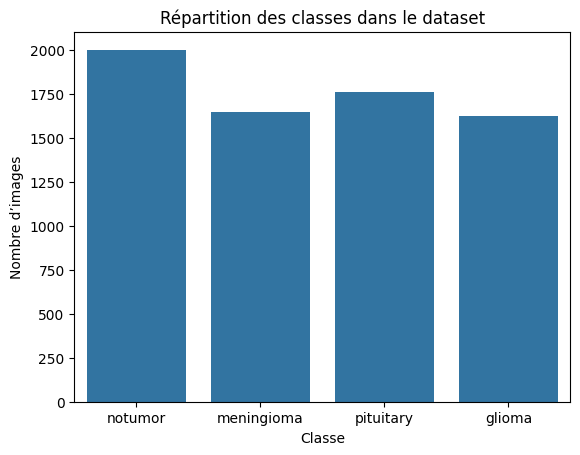

In [37]:
sns.countplot(x=labels)  ## le x peut etre une dataframe ou liste , il complte le nombre d occurences de chaq categorie
plt.title("Répartition des classes dans le dataset")
plt.xlabel("Classe")
plt.ylabel("Nombre d’images")
plt.show()

** Montrer un échantillon d’images pour chaque classe. 
    les etapes a suivre pour afficher les echantillons 
        definir le nombre des echantillons a afficher par classe
        on appelle a la fonction no.unique qui prend en parametre une liste et envoie une nouvelle liste avec les noms uniques sans doublons 
        plt.figure(x , y )  , la largeur et hauteur pour chaque fig
        enumerate(liste) => return  index , valeur   
        idxs contient les indices des image apprtenant a chaque classe parmi les classes enumerates  : print(f"{cls} : {idxs}")
                glioma : [   8    9   12 ... 7006 7014 7022]
                meningioma : [   1    2    6 ... 7007 7008 7017]
                notumor : [   0    3   13 ... 7018 7019 7020]
                pituitary : [   4    5   11 ... 7015 7016 7021]
            
        


glioma : [   9   10   17 ... 7015 7019 7022]
meningioma : [   1    7   11 ... 7017 7018 7021]
notumor : [   0    2    8 ... 7012 7016 7020]
pituitary : [   3    4    5 ... 7003 7005 7008]


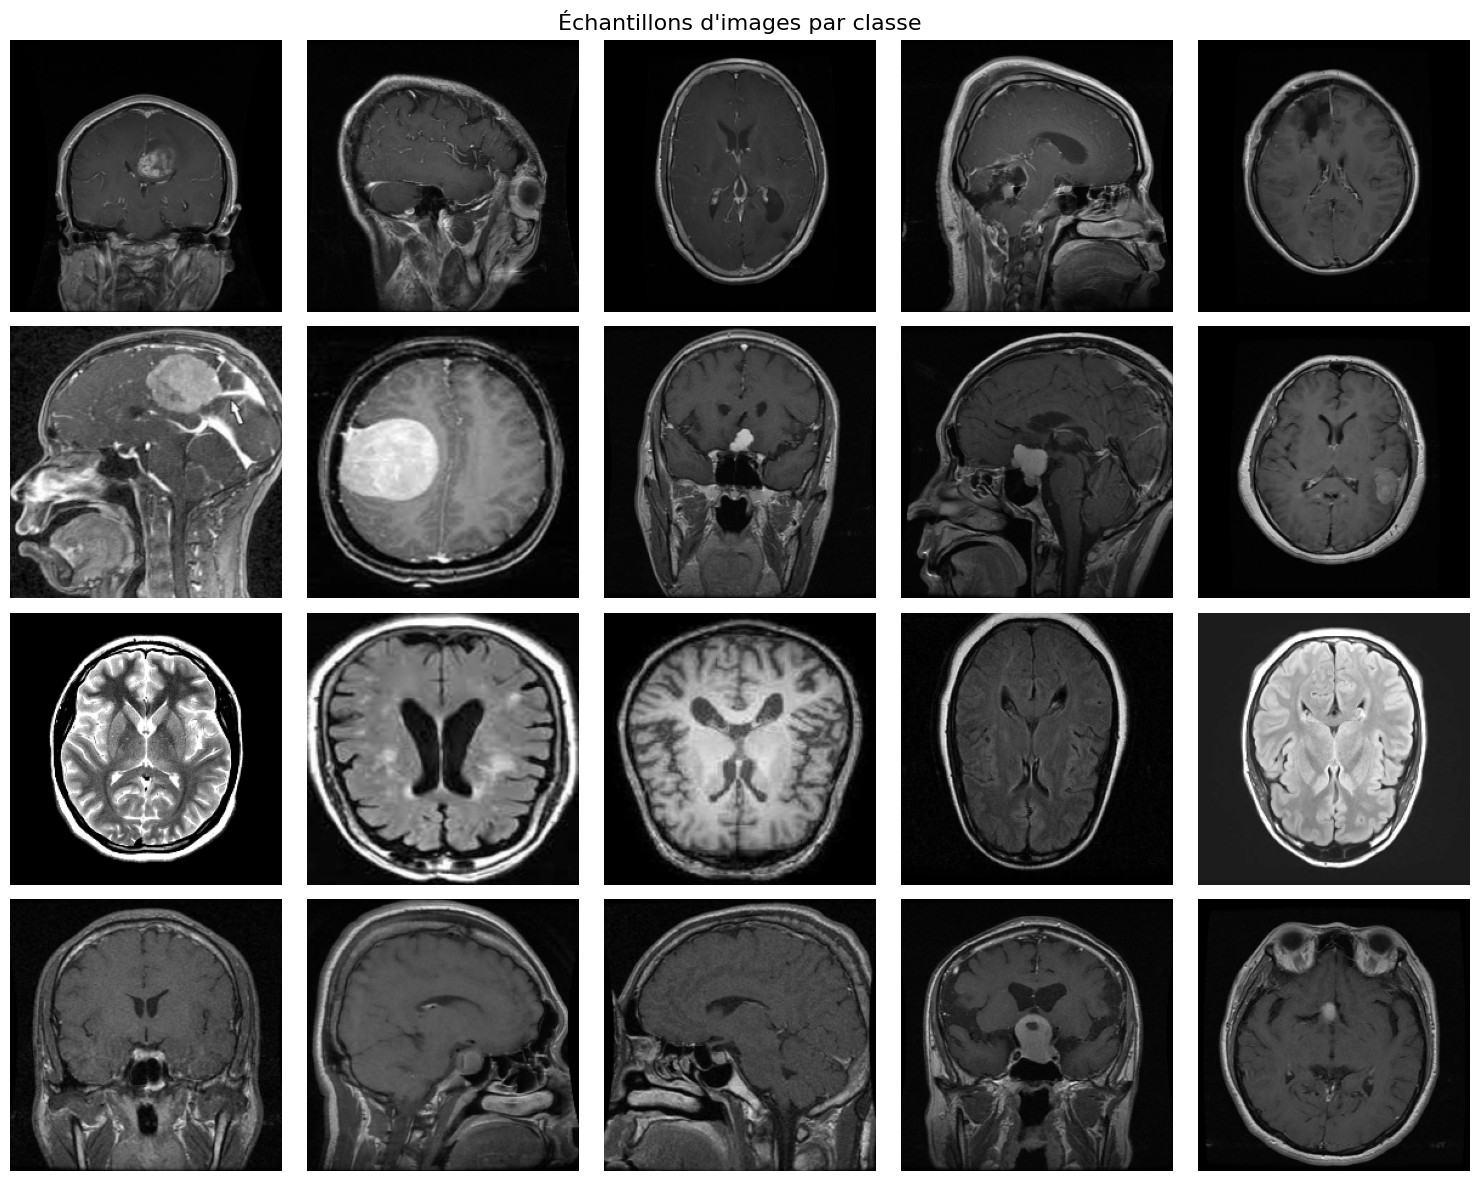

In [38]:


# Définir le nombre d'images à afficher par classe
n_samples_per_class = 5

# Obtenir les classes uniques
classes = np.unique(labels)   

# Créer la figure
plt.figure(figsize=(15, len(classes)*3))

# Parcourir chaque classe
for i, cls in enumerate(classes):
    # Trouver les indices des images appartenant à cette classe
    idxs = np.where(labels == cls)[0]
    print(f"{cls} : {idxs}")
    # Sélectionner aléatoirement n_samples_per_class images
    selected_idxs = np.random.choice(idxs, size=n_samples_per_class, replace=False)
    dict_labels_list_images_index[cls] = idxs
    for j, idx in enumerate(selected_idxs):
        plt_idx = i * n_samples_per_class + j + 1
        plt.subplot(len(classes), n_samples_per_class, plt_idx)
        plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))  # Convertir BGR -> RGB
        plt.axis('off')
        if j == 0:
            plt.ylabel(cls, fontsize=12)
            
plt.suptitle("Échantillons d'images par classe", fontsize=16)
plt.tight_layout()
plt.show()


** Vérifier l’équilibre entre les classes et appliquer un rééquilibrage si nécessaire. :
    d apres les resultats ainsi que histogramme on remarque qu il y une desequilibre entre les classes , il y a deux solution soit supprimer soit ajouter des images , dans notre cas on va ajouter des images , dans les classes pour avoir 2000 images par classes
    on appelle cette technique  " Sur-échantillonnage (Oversampling) "  , on aura besoin d importer "from tensorflow.keras.preprocessing.image import ImageDataGenerator"  pour utlise la fonction ImageDataGenerator

    les etapes l'equilibre : 

        1.Déterminer le nombre maximal d’images ; ici 2000 
        2.Générer les images pour les classes minoritaires
            # Générateur pour créer des images artificielles
                datagen = ImageDataGenerator(
                    rotation_range=20,       # rotation aléatoire
                    width_shift_range=0.1,   # décalage horizontal
                    height_shift_range=0.1,  # décalage vertical
                    zoom_range=0.1,          # zoom aléatoire
                    horizontal_flip=True     # retournement horizontal
                )

        3.Combiner avec le dataset original


In [39]:
print(dict_labels_list_images_index)
for label in dict_labels_list_images_index:
    num_images = len(dict_labels_list_images_index[label])
    dict_labels_images_count[label] = num_images
    print(f"{label} : {num_images} images")

# max
max_nb_img = max(dict_labels_images_count.values())
print(f"\n nombre max des images {max_nb_img}")

{np.str_('glioma'): array([   9,   10,   17, ..., 7015, 7019, 7022], shape=(1621,)), np.str_('meningioma'): array([   1,    7,   11, ..., 7017, 7018, 7021], shape=(1645,)), np.str_('notumor'): array([   0,    2,    8, ..., 7012, 7016, 7020], shape=(2000,)), np.str_('pituitary'): array([   3,    4,    5, ..., 7003, 7005, 7008], shape=(1757,))}
glioma : 1621 images
meningioma : 1645 images
notumor : 2000 images
pituitary : 1757 images

 nombre max des images 2000


In [40]:
def fun_dict_labels_list_images_index(dict_labels_list_images_index) :
    for label in dict_labels_list_images_index:
        num_images = len(dict_labels_list_images_index[label])
        dict_labels_images_count[label] = num_images
        return  dict_labels_images_count 
print(fun_dict_labels_list_images_index(dict_labels_list_images_index))

{np.str_('glioma'): 1621, np.str_('meningioma'): 1645, np.str_('notumor'): 2000, np.str_('pituitary'): 1757}


In [19]:
# df = pd.DataFrame({'image': list(images), 'label': labels})
# count_by_class = df['label'].value_counts()
# max_nb_img = count_by_class.max()
# print(count_by_class)
# print("---")
# print("le nombre maximal d’images" , max_nb_img  , "Le nom de la classe :",count_by_class.idxmax())
# dict_labels_images_count = dict(df['label'].value_counts())


In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Création du générateur d'images
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

blanced_images = []
blanced_labels = []

for label, count_img in dict_labels_images_count.items():
    # Récupérer les indices des images de cette classe
    idxs = dict_labels_list_images_index[label]
    while count_img < max_nb_img:
        # Choisir une image existante aléatoire
        idx = np.random.choice(idxs)
        img = images[idx]

        # Ajouter une dimension pour le batch
        img_batch = np.expand_dims(img, 0)

        # Générer une image augmentée
        batch = next(datagen.flow(img_batch, batch_size=1))
        new_gen_img = batch[0].astype(np.uint8)

        # Ajouter l'image et son label
        blanced_images.append(new_gen_img)
        blanced_labels.append(label)
        count_img += 1

    

# Convertir en arrays
blanced_images = np.array(blanced_images)
blanced_labels = np.array(blanced_labels)


# Concaténer les arrays
all_images = np.concatenate((images, blanced_images), axis=0)
all_labels = np.concatenate((labels, blanced_labels), axis=0)

print("Nombre total de labels :", len(all_labels))
print("Nombre d'images générées :", len(blanced_images))



Nombre total de labels : 8000
Nombre d'images générées : 977


** Transformer les étiquettes textuelles en format numérique (ex. avec LabelEncoder ou to_categorical).


In [42]:
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
labels_encoded = le.fit_transform(labels) 
labels_onehot = to_categorical(labels_encoded)
print("Shape du one-hot :", labels_onehot.shape)
print(labels_onehot[:5])  # afficher les 5 premiers vecteurs


Shape du one-hot : (7023, 4)
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


** Normaliser les valeurs des pixels dans la plage [0, 1].

In [43]:
images = np.array(images, dtype='float32') / 255.0

** Diviser les données en ensembles d’entraînement et de test.


In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    images, labels_onehot,       
    test_size=0.2,                
    random_state=42,            
    stratify=labels_encoded       # pour garder le même ratio de classes
)

## Conception du Modèle CNN
1_ Définir l’architecture CNN (Conv2D + MaxPooling + Dropout + Dense) avec des paramètres optimaux.



2_ Choisir les meilleures fonctions d’activation pour les couches cachées et la couche de sortie.

**** pour les couches cachées :Relu
     formule : f(x)= max(0,x)
     on a choisi relu car 
     _ on active juste les neurones pertinents on prend les valeur positives et pour les valeurs negatives devient 0
     _ rapide a calculer : accelere l'apprentisssage
     _ evite les gradients tres petits 
**** pour la couche de sortie : Softmax
     _ transforme les sorties en probablités pour chaque classe
     _ la somme de toutes les probabilites =1
     _ideal pour classifiication multi-classes


In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np

num_classes = len(np.unique(labels))  # à définir selon ton dataset

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])


3_ Compiler le modèle (ex. : Optimiseur Adam, fonction de perte categorical_crossentropy).


pour optimiser notre modele on fait recours a optimiseur adm ainsi que la fonction de perte 
on commence par Categorical Crossentropy qui mesure l’erreur entre la prédiction du modèle et le vrai label.
puis optimiseur  Adam utilise cette erreur pour ajuster les poids du réseau et améliorer la prédiction.

**** Adam (optimiseur)

Quand il intervient ?

Pendant l’entraînement du modèle, après chaque batch d’images.

Son rôle : mettre à jour les poids des neurones pour que le modèle fasse moins d’erreurs sur tes images IRM.

Exemple :

Tu passes une image IRM d’un gliome dans ton CNN.

Le modèle prédit : [0.2, 0.1, 0.6, 0.1] (probabilités pour [glioma, meningioma, notumor, pituitary])

Le vrai label (one-hot) est [1, 0, 0, 0]

Adam regarde la différence entre la prédiction et la vérité → et ajuste tous les filtres/convolutions dans le réseau pour que la prochaine fois, le modèle prédit mieux.



**** Categorical Crossentropy (fonction de perte)

Quand elle intervient ?

Toujours pendant l’entraînement, juste avant qu’Adam mette à jour les poids.

Elle calcule combien la prédiction du modèle est mauvaise par rapport au vrai label.

Exemple avec ton brief :

Même image IRM : vrai label [1, 0, 0, 0]

Modèle prédit [0.2, 0.1, 0.6, 0.1]

Crossentropy calcule “perte = 1.609” (exemple numérique) → plus la prédiction est loin du vrai label, plus la perte est grande

Adam utilise cette perte pour corriger les poids → le modèle apprend à mieux classer les gliomes.

En résumé simple :

Tu donnes une image au modèle.

Le modèle prédit des probabilités.

Categorical Crossentropy mesure l’erreur de prédiction.

Adam ajuste les poids du CNN pour réduire cette erreur.

Répète pour toutes les images, epoch après epoch → le modèle s’améliore.

In [47]:
# Compilation du modèle
model.compile(
    optimizer='adam',                 
    loss='categorical_crossentropy',  
    metrics=['accuracy']              
)


4_ Utiliser les fonctions model.summary() et plot_model() pour vérifier l’architecture du modèle.
**** model.summary() va afficher dans la console toutes les couches du modèle, leurs sorties et le nombre de paramètres.

plot_model() crée un fichier image (cnn_model.png) avec une représentation graphique du CNN. show_shapes=True permet de voir la taille des sorties de chaque couche.


In [26]:
! pip install pydot

In [48]:
from tensorflow.keras.utils import plot_model

# Afficher un résumé du modèle
model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


5_ Déterminer les hyperparamètres (taux d’apprentissage, nombre d’époques, taille de batch).


In [49]:
# Hyperparamètres principaux
learning_rate = 0.001   # Taux d'apprentissage pour Adam
epochs = 20             # Nombre d'époques pour l'entraînement
batch_size = 32         # Nombre d'images traitées à chaque itératio

In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='../models/best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

6_Utiliser la bibliothèque time pour mesurer la durée de l’entraînement.

In [51]:
start_time = time.time()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[checkpoint]
)

end_time = time.time()
training_time = end_time - start_time
print(f"Durée totale de l'entraînement : {training_time:.2f} secondes")
print(f"Durée totale en minute : {training_time/60:.2f} minutes")

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5418 - loss: 1.0549

176/176 ━━━━━━━━━━━━━━━━━━━━ 59s 320ms/step - accuracy: 0.6686 - loss: 0.7887 - val_accuracy: 0.8363 - val_loss: 0.4457
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8341 - loss: 0.4357

176/176 ━━━━━━━━━━━━━━━━━━━━ 55s 312ms/step - accuracy: 0.8467 - loss: 0.4007 - val_accuracy: 0.8861 - val_loss: 0.2908
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8975 - loss: 0.2839

176/176 ━━━━━━━━━━━━━━━━━━━━ 84s 322ms/step - accuracy: 0.8948 - loss: 0.2772 - val_accuracy: 0.8968 - val_loss: 0.2591
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9286 - loss: 0.1981

176/176 ━━━━━━━━━━━━━━━━━━━━ 85s 483ms/step - accuracy: 0.9297 - loss: 0.1941 - val_accuracy: 0.9288 - val_loss: 0.1695
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9456 - loss: 0.1589

176/176 ━━━━━━━━━━━━━━━━━━━━ 111s 629ms/step - accuracy: 0.9470 - loss: 0.1518 - val_accuracy: 0.9559 - val_loss: 0.1307
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 109s 621ms/step - accuracy: 0.9566 - loss: 0.1147 - val_accuracy: 0.9438 - val_loss: 0.1495
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9700 - loss: 0.0843

176/176 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.9662 - loss: 0.0926 - val_accuracy: 0.9609 - val_loss: 0.1285
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 55s 311ms/step - accuracy: 0.9722 - loss: 0.0750 - val_accuracy: 0.9495 - val_loss: 0.1470
Epoch 9/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9768 - loss: 0.0713

176/176 ━━━━━━━━━━━━━━━━━━━━ 65s 372ms/step - accuracy: 0.9756 - loss: 0.0667 - val_accuracy: 0.9715 - val_loss: 0.1111
Epoch 10/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 107s 609ms/step - accuracy: 0.9840 - loss: 0.0466 - val_accuracy: 0.9601 - val_loss: 0.1435
Epoch 11/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.9652 - loss: 0.0980

176/176 ━━━━━━━━━━━━━━━━━━━━ 113s 639ms/step - accuracy: 0.9744 - loss: 0.0731 - val_accuracy: 0.9737 - val_loss: 0.1216
Epoch 12/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 92s 524ms/step - accuracy: 0.9845 - loss: 0.0396 - val_accuracy: 0.9665 - val_loss: 0.1361
Epoch 13/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 125s 711ms/step - accuracy: 0.9867 - loss: 0.0355 - val_accuracy: 0.9722 - val_loss: 0.1021
Epoch 14/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 105s 275ms/step - accuracy: 0.9867 - loss: 0.0368 - val_accuracy: 0.9708 - val_loss: 0.1279
Epoch 15/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 249ms/step - accuracy: 0.9858 - loss: 0.0461 - val_accuracy: 0.9630 - val_loss: 0.1394
Epoch 16/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 42s 240ms/step - accuracy: 0.9886 - loss: 0.0352 - val_accuracy: 0.9715 - val_loss: 0.1278
Epoch 17/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 46s 263ms/step - accuracy: 0.9884 - loss: 0.0332 - val_accuracy: 0.9737 - val_loss: 0.1155
Epoch 18/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 54s 305ms/step - accuracy: 0.9884 - loss: 0.

In [ ]:
# import time

# start_time = time.time()  # enregistre le temps de début

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=20,
#     batch_size=32
# )

# end_time = time.time()  # enregistre le temps de fin

# training_time = end_time - start_time
# print(f"Durée totale de l'entraînement : {training_time:.2f} secondes")
# print(f"Durée totale en munite: {training_time/60:.2f} minutes")

NameError: name 'model' is not defined

** Évaluer les performances sur l’ensemble de test. 

** Visualiser les courbes d’apprentissage (accuracy / loss). 


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9737 - loss: 0.1216
Précision sur l'ensemble de test : 0.9737
Perte sur l'ensemble de test : 0.1216


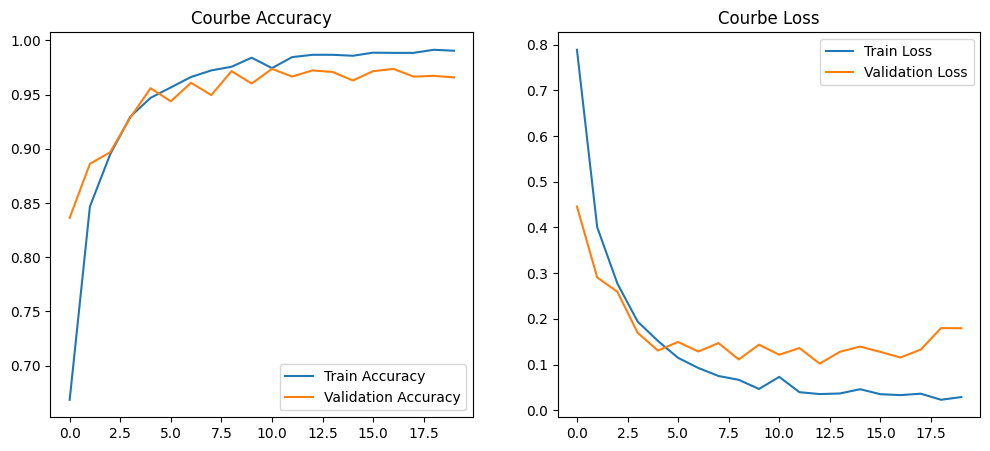

NameError: name 'y' is not defined

In [54]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

best_model = load_model('../models/best_model.h5')
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Précision sur l'ensemble de test : {test_accuracy:.4f}")
print(f"Perte sur l'ensemble de test : {test_loss:.4f}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Courbe Accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Courbe Loss')
plt.show()



Générer une matrice de confusion et un rapport de classification.

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


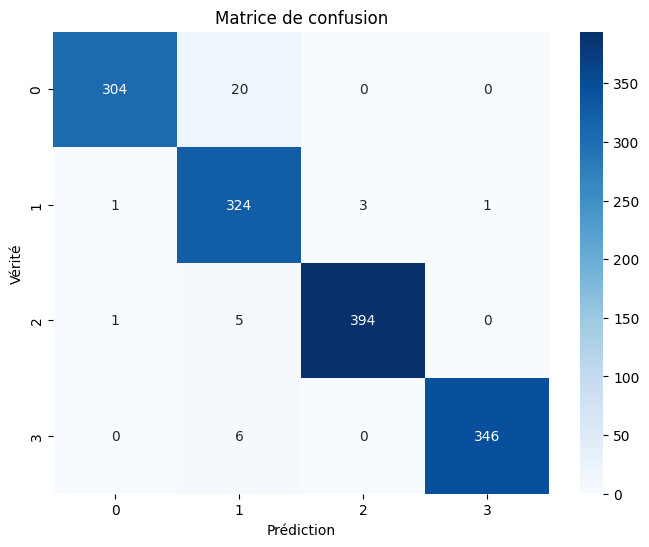

In [59]:
y_pred = best_model.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.ylabel('Vérité')
plt.show()






In [58]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97       324
           1       0.91      0.98      0.95       329
           2       0.99      0.98      0.99       400
           3       1.00      0.98      0.99       352

    accuracy                           0.97      1405
   macro avg       0.97      0.97      0.97      1405
weighted avg       0.98      0.97      0.97      1405



** Afficher des exemples de prédictions correctes et incorrectes.

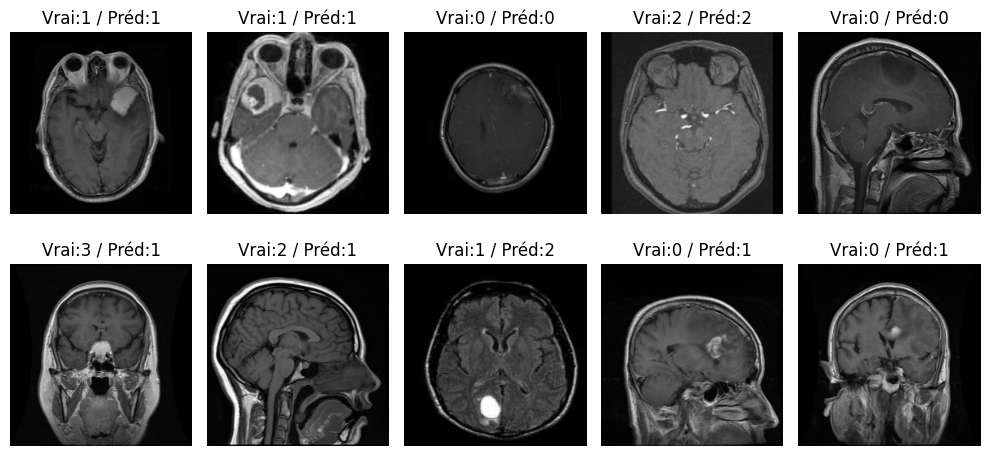

In [57]:
correct_idx = np.where(y_pred_classes == y_true)[0]
incorrect_idx = np.where(y_pred_classes != y_true)[0]

plt.figure(figsize=(10,5))
for i, idx in enumerate(correct_idx[:5]):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[idx])
    plt.title(f"Vrai:{y_true[idx]} / Préd:{y_pred_classes[idx]}")
    plt.axis('off')

for i, idx in enumerate(incorrect_idx[:5]):
    plt.subplot(2,5,i+6)
    plt.imshow(X_test[idx])
    plt.title(f"Vrai:{y_true[idx]} / Préd:{y_pred_classes[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Déploiement / Utilisation
1_ Créer une fonction predict_image(path) pour tester une image.

** Créer une fonction predict_image(path) qui :

Charge une image depuis un chemin (path),

La prétraite pour qu’elle soit compatible avec le modèle (taille, normalisation, dimensions),

Fait une prédiction à l’aide du modèle entraîné,

Affiche le résultat (classe prédite + probabilité).

In [61]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Exemple de classes (adapter selon votre dataset)
labels_name = np.unique(labels)   #  les noms des classes : ['glioma' 'meningioma' 'notumor' 'pituitary']

# Charger le modèle entraîné
model = load_model('../models/best_model.h5', compile=False)


def predict_image(path):
    img = image.load_img(path, target_size=(224, 224))  # 1. Charger et redimensionner
    img_array = image.img_to_array(img)                 # 2. Convertir en tableau numpy
    img_array = np.expand_dims(img_array, axis=0)       # 3. Ajouter la dimension batch
    img_array = img_array / 255.0                       # 4. Normaliser entre 0 et 1

    prediction = model.predict(img_array)               # 5. Faire la prédiction
    predicted_class = np.argmax(prediction, axis=1)[0]  # 6. Classe prédite (indice)
    confidence = np.max(prediction)                     # 7. Probabilité associée

    print(f"Classe prédite : {labels_name[predicted_class]}")
    print(f"Confiance : {confidence*100:.2f}%")
    return labels_name[predicted_class], confidence


** test avec img existante 

In [63]:
predict_image("../test_images/image_Te-gl_0027.jpg") ## image de glioma image_Te-gl_0027


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Classe prédite : glioma
Confiance : 100.00%


(np.str_('glioma'), np.float32(1.0))